In [7]:
import math
import pickle
import time
from functools import reduce
from pandarallel import pandarallel

import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots
from scipy import stats
from utils.my_cache import cache_wrapper
from utils.functions import *

from csmarapi.ReportUtil import ReportUtil


In [3]:
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
csmar = CsmarService()
pandarallel.initialize()

csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Tue 18 Oct 2022 09:02:38 CsmarService.py INFO User login succeed


## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

- SVC related: `previous research`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic; stock fund adjusted net asset value (2005/6-2019/6)

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

AMAC

In [8]:
from data.AMAC.amac_full_market_value import amac_full_market_value

JoinQuant

In [9]:
from data.JoinQuant.jq_all_fund_brief import *
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.JoinQuant.jq_all_stocks_brief import jq_all_stocks_brief
from data.JoinQuant.jq_stock_classification import jq_stock_classification

Win.d

In [18]:
from data.Wind.wind_validate_share_nav import *
from data.Wind.wind_validate_stock_fund_adj_nav import wind_validate_stock_fund_adj_nav
from data.Wind.wind_stock_classification import *

CSMAR

In [11]:
from data.CSMAR.TRD_Co import csmar_stock_classification
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.invest_detail import csmar_invest_detail
from data.CSMAR.TRD_Mnth import csmar_monthly_stock_mkt_value

SVC

In [16]:
from data.SVC.svc_source import svc_source

TwoStep

In [17]:
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

## **II. Market Statistic**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.Wind.wind_validate_share_nav import *
from utils.functions import *

auth success 


split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| all | all fund share | all fund nav |
| blend | blend fund share | blend fund nav |

In [ ]:
wind_validate_share = wind_validate_share_nav.loc['基金份额', slice(None)]
wind_validate_share.columns = wind_validate_share.columns.str.split('.').str[0]
wind_validate_share = wind_validate_share[ ~ wind_validate_share.index.duplicated(keep='last')]

In [20]:
wind_validate_nav = wind_validate_share_nav.loc['单位净值', slice(None)]
wind_validate_nav.columns = wind_validate_nav.columns.str.split('.').str[0]
wind_validate_nav = wind_validate_nav[ ~ wind_validate_nav.index.duplicated(keep='last')]

In [ ]:
wind_stock_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [22]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_num = pd.notna(wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_num.index = wind_blend_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_mkt_value = (wind_blend_fund_share * wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_mkt_value.index  = wind_blend_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

align JoinQuant && CSMAR data

In [23]:
csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')


In [24]:
selected_month = 6

csmar_share_info_6 = csmar_share_info[csmar_share_info.index.month == selected_month]
csmar_nav_monthly_6 = csmar_nav_monthly[csmar_nav_monthly.index.month == selected_month]

csmar_blend_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_6.columns)

csmar_co_time_6 = np.intersect1d(csmar_share_info_6.index, csmar_nav_monthly_6.index)




In [25]:
csmar_blend_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_blend_mkt_value_jq_classify.index = csmar_blend_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

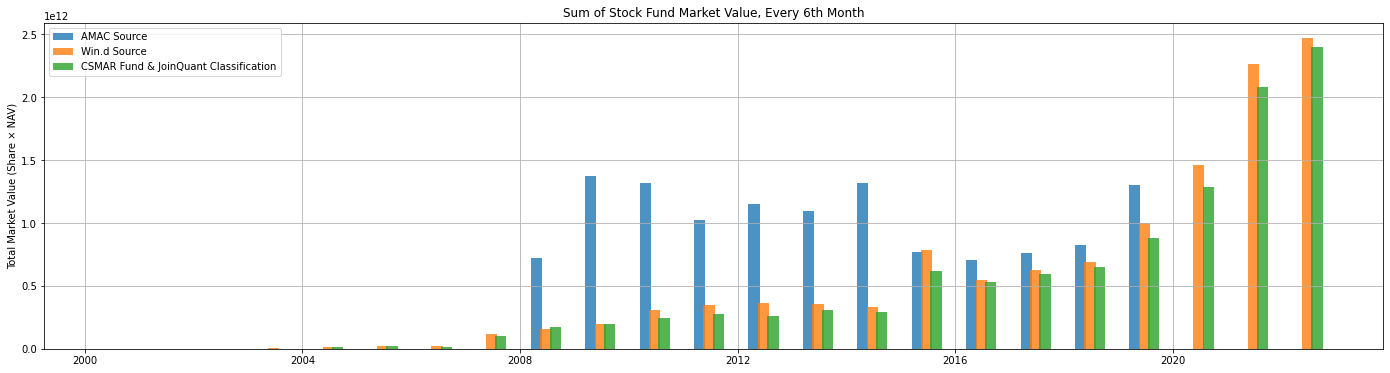

In [26]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.股票基金.index - pd.Timedelta('10W'), amac_full_market_value.股票基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund Market Value, Every 6th Month')
plt.legend()

blend funds market value

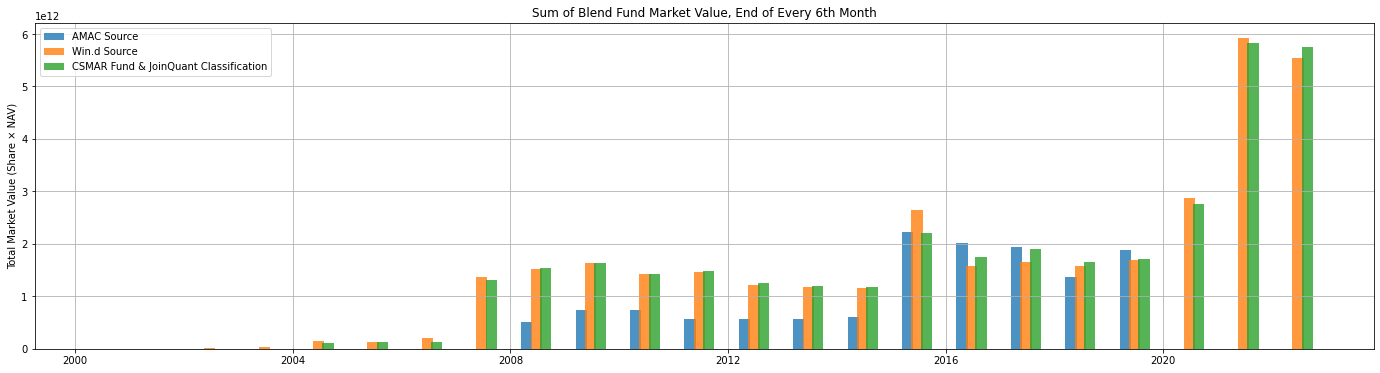

In [27]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), amac_full_market_value.混合基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), wind_blend_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_blend_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Blend Fund Market Value, End of Every 6th Month')
plt.legend()

(stock + blend) funds market value

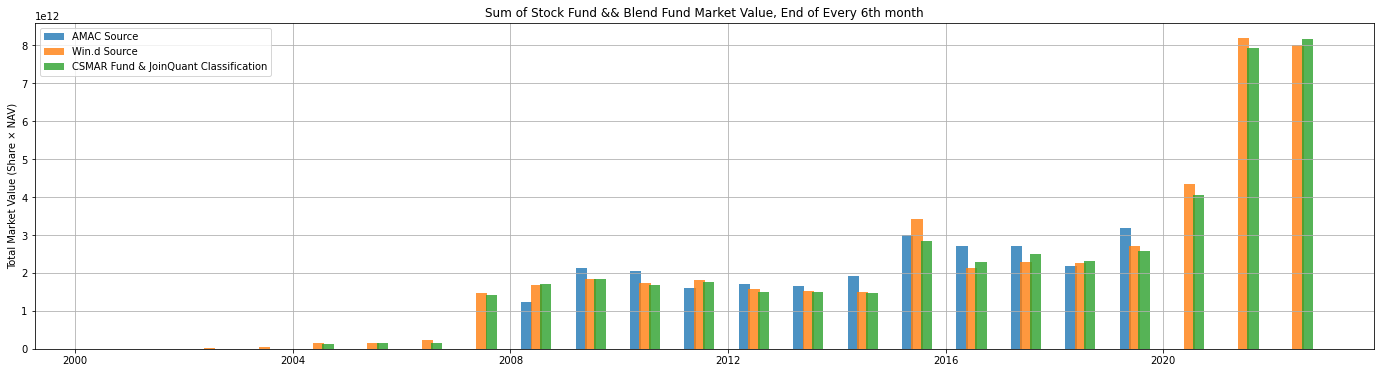

In [28]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), (amac_full_market_value.混合基金.values + amac_full_market_value.股票基金.values) * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_blend_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_blend_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund && Blend Fund Market Value, End of Every 6th month')
plt.legend()

fund counts

In [29]:
csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

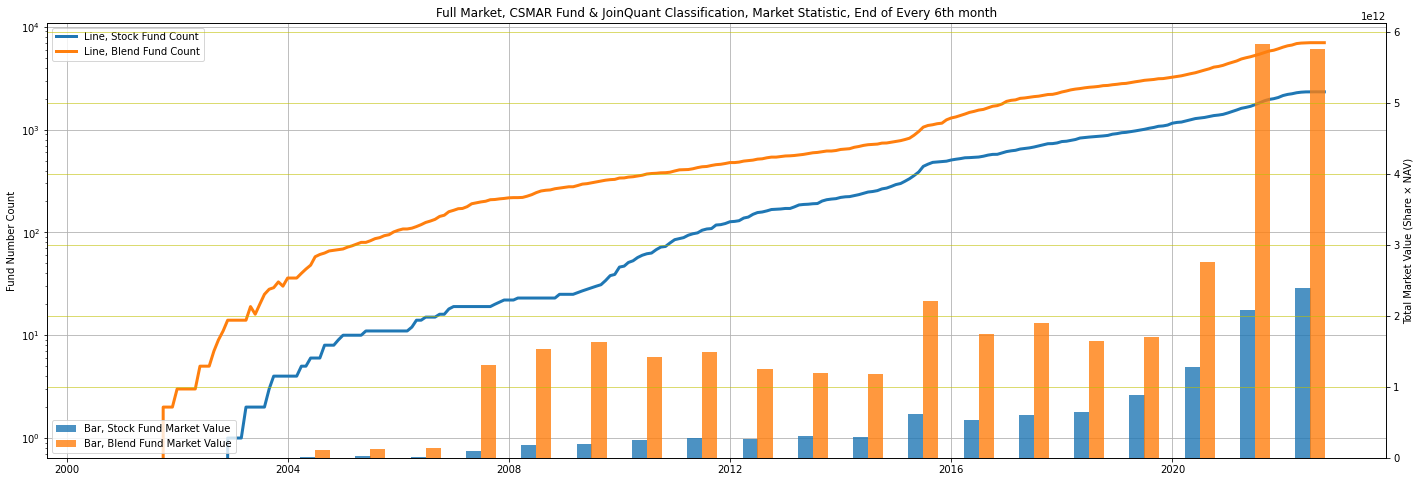

In [30]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

csmar_nav_monthly_6.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


ax1.plot(csmar_stock_fund_count, linewidth=3, label='Line, Stock Fund Count')
ax1.plot(csmar_blend_fund_count, linewidth=3, label='Line, Blend Fund Count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()
ax1.set_ylabel('Fund Number Count')

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='Bar, Stock Fund Market Value', alpha=.8)

plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_blend_mkt_value_jq_classify.values, width=100, label='Bar, Blend Fund Market Value', alpha=.8)

plt.title('Full Market, CSMAR Fund & JoinQuant Classification, Market Statistic, End of Every 6th month')

ax2.grid(color='y', alpha=.7)
plt.ylabel('Total Market Value (Share × NAV)')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.show()


## **III. Filters**

In [ ]:
from functools import reduce

import numpy as np
import pandas as pd

from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

### preview

In [39]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(csmar_nav_daily.Symbol.unique().astype(str), 6), jq_all_fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(jq_all_fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'operate_mode', 'underlying_asset_type', 'start_date']]


In [40]:
specs = [[{'type':'domain'}] * 2]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['JoinQuant Asset Type', 'JoinQuant Operation Mode'])
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金非 ETF 类基金、非 QDII 类基金

<!-- （4）主动管理标识为 1 或者为空； -->

In [41]:
final_main_info

,main_code,operate_mode,underlying_asset_type,start_date
0,000001,开放式基金,混合型,2001-12
1,000003,开放式基金,债券型,2013-03
2,000004,开放式基金,债券型,2013-03
3,000005,开放式基金,债券型,2013-03
4,000006,开放式基金,混合型,2019-03
...,...,...,...,...
16387,968083,开放式基金,债券型,2020-04
16388,968084,开放式基金,债券型,2020-04
16389,968085,开放式基金,债券型,2020-04
16390,968086,开放式基金,债券型,2020-04


In [42]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = np.logical_and(final_main_info.operate_mode != 'ETF', final_main_info.operate_mode != 'QDII')

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.62005857, 0.93191801])

In [43]:

def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16392 to 10164
filter 2: 10164 to 9253


In [44]:
final_main_info = final_main_info[filters_]
final_main_info.set_index('main_code').sort_index()

,operate_mode,underlying_asset_type,start_date
main_code,,,
000001,开放式基金,混合型,2001-12
000006,开放式基金,混合型,2019-03
000011,开放式基金,混合型,2004-08
000017,开放式基金,混合型,2013-03
000020,开放式基金,混合型,2013-03
...,...,...,...
968045,开放式基金,股票型,2019-03
968046,开放式基金,股票型,2019-03
968047,开放式基金,股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [45]:
indexes = pd.MultiIndex.from_product([final_main_info.main_code.sort_values().values, pd.date_range('2000-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[csmar_nav_monthly[final_main_info.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2001-12        开放式基金                   混合型    2001-12
       2002-01        开放式基金                   混合型    2001-12
       2002-02        开放式基金                   混合型    2001-12
       2002-03        开放式基金                   混合型    2001-12
       2002-04        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
968049 2022-05        开放式基金                   股票型    2019-03
       2022-06        开放式基金                   股票型    2019-03
       2022-07        开放式基金                   股票型    2019-03
       2022-08        开放式基金                   股票型    2019-03
       2022-09        开放式基金                   股票型    2019-03

[418488 rows x 3 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [46]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info)} to {record_shape}'

'in view of 2022, filter 3: 9253 to 7157'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

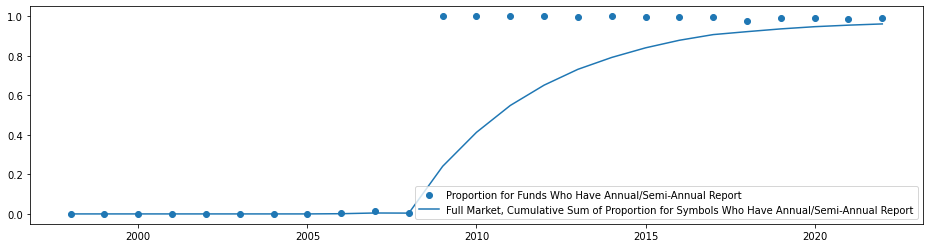

In [47]:
csmar_fund_allocation['report_type_check'] = csmar_fund_allocation.Date.dt.year
report_type_check = csmar_fund_allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='Proportion for Funds Who Have Annual/Semi-Annual Report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='Full Market, Cumulative Sum of Proportion for Symbols Who Have Annual/Semi-Annual Report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [48]:
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.ReportTypeID.isin([2, 5, 6])]
csmar_fund_allocation = pd.merge(csmar_fund_allocation, csmar_symbol_code_mapping, on='MasterFundCode', how='left')
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[csmar_fund_allocation.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [49]:
filter_4 = csmar_fund_allocation[(csmar_fund_allocation.Equity / csmar_fund_allocation.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2003-06        开放式基金                   混合型    2001-12
       2003-07        开放式基金                   混合型    2001-12
       2003-08        开放式基金                   混合型    2001-12
       2003-09        开放式基金                   混合型    2001-12
       2003-10        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
952009 2022-05        封闭式基金                   混合型    2020-01
       2022-06        封闭式基金                   混合型    2020-01
       2022-07        封闭式基金                   混合型    2020-01
       2022-08        封闭式基金                   混合型    2020-01
       2022-09        封闭式基金                   混合型    2020-01

[235912 rows x 3 columns]

In [50]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 7157 to 5291'

### 4. full data

reset nav

In [52]:
csmar_nav_monthly = pd.Series(csmar_nav_monthly.stack().swaplevel(), name='NAV')
csmar_nav_monthly = pd.DataFrame(csmar_nav_monthly).reset_index()

merge data

In [53]:
main_data = pd.merge(main_data, csmar_nav_monthly, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [54]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

combine csmar category

In [55]:
csmar_category_symbol_mapping = pd.merge(csmar_maininfo[['MasterFundCode', 'Category']].drop_duplicates(), \
    csmar_symbol_code_mapping, on='MasterFundCode', how='left')[['Category', 'Symbol']]
csmar_category_symbol_mapping = csmar_category_symbol_mapping.drop_duplicates().reset_index(drop=True)
csmar_category_symbol_mapping = csmar_category_symbol_mapping.groupby('Symbol').last()

main_data = pd.merge(main_data.reset_index(), csmar_category_symbol_mapping, on='Symbol').set_index(['Symbol', 'Date'])
main_data

operate_mode underlying_asset_type  ... SplitRatio Category_y
Symbol Date                                        ...                      
000001 2003-06        开放式基金                   混合型  ...        1.0      混合型基金
       2003-07        开放式基金                   混合型  ...        1.0      混合型基金
       2003-08        开放式基金                   混合型  ...        1.0      混合型基金
       2003-09        开放式基金                   混合型  ...        1.0      混合型基金
       2003-10        开放式基金                   混合型  ...        1.0      混合型基金
...                     ...                   ...  ...        ...        ...
952009 2022-05        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-06        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-07        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-08        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-09        封闭式基金                   混合型  ...        1.0      混合型基金

[235808 rows x 8 columns]

## **IV. Overall Performance**

### Return

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

#### 1. prepare

In [ ]:
from functools import reduce

import numpy as np
import pandas as pd

from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

NAV_shift calculation

In [58]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

split into stock fund and blend fund

apply formula

In [59]:
blend_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']


return_of_csmar_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_csmar_blend_fund = blend_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_all_fund = main_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)


market value weight generation

In [60]:
MONTH_OF_YEAR = 6

csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

csmar_share_info_yearly = csmar_share_info[csmar_share_info.index.month == MONTH_OF_YEAR]
csmar_nav_yearly = csmar_nav_monthly[csmar_nav_monthly.index.month == MONTH_OF_YEAR]

csmar_co_time_6 = np.intersect1d(csmar_share_info_yearly.index, csmar_nav_yearly.index)

csmar_blend_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_yearly.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_yearly.columns)



csmar_stock_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])

csmar_stock_fund_weight_yearly = pd.concat([csmar_stock_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_stock_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_stock_fund_weight_yearly.columns)])

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.resample('M').ffill()

stock_fund_dates = return_of_csmar_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_csmar_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)
print(f'{stock_fund_new} will not be used')

stock_fund_funds = np.intersect1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.loc[stock_fund_dates, stock_fund_funds]
csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.div(csmar_stock_fund_weight_yearly.sum(axis=1), axis=0)

[] will not be used


In [61]:

csmar_blend_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
csmar_blend_fund_weight_yearly = pd.concat([csmar_blend_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_blend_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_blend_fund_weight_yearly.columns)])
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.resample('M').ffill()

blend_fund_dates = return_of_csmar_blend_fund.unstack(level=0).index
blend_fund_funds = return_of_csmar_blend_fund.unstack(level=0).columns

blend_fund_new = np.setdiff1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)
print(f'{blend_fund_new} will not be used')
blend_fund_funds = np.intersect1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)

csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.loc[blend_fund_dates, blend_fund_funds]
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.div(csmar_blend_fund_weight_yearly.sum(axis=1), axis=0)


['960002' '960004'] will not be used


#### 2. analysis

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from IPython.display import display

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund
from data.TwoStepData.regression_source import regression_source
from utils.functions import *


use data later than 2005-06

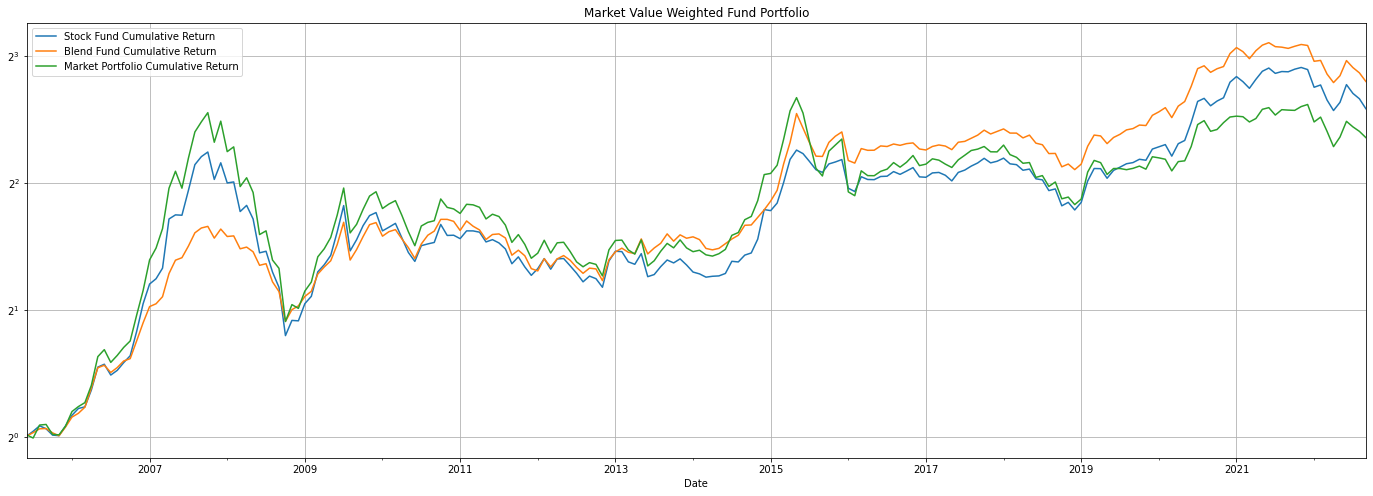

In [64]:
plt.figure(figsize=(24,8))

(((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
(((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc['2005-6': ].mktrf + svc_source.loc['2005-6': ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.yscale('log', base=2)
plt.title('Market Value Weighted Fund Portfolio')
plt.grid()
plt.legend()
plt.show()


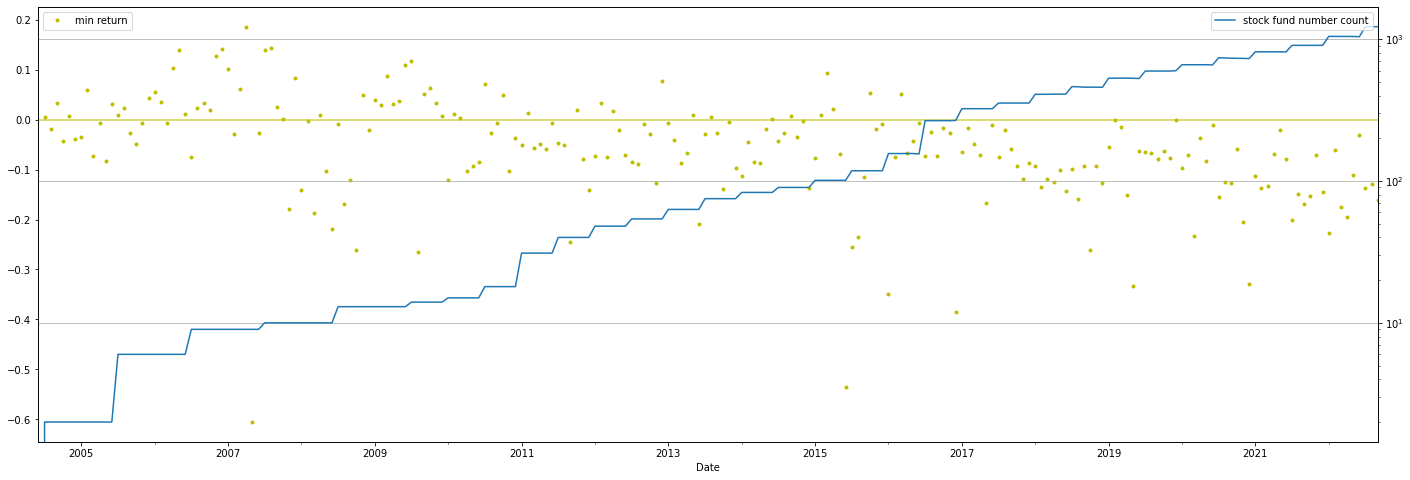

In [65]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['min'].plot(ax=ax1, style='.', label='min return', color='y')
ax1.legend()
ax1.legend(loc='upper left')
ax1.axhline(color='y', alpha=.7)
ax2 = ax1.twinx()
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['count'].plot(ax=ax2, label='stock fund number count')
ax2.grid()
ax2.set_yscale('log')
ax2.legend(loc='upper right')

In [50]:
# plt.figure(figsize=(24,8))
# return_of_stock_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
# return_of_blend_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
# plt.yscale('log', base=2)
# plt.title('1/N Weighted Fund Portfolio')
# plt.grid()
# plt.legend()

why use data later than 2005-06?

In [67]:
co_time = np.intersect1d(csmar_share_info.index, csmar_nav_monthly.index)
co_stocks = np.intersect1d(csmar_share_info.columns, csmar_nav_monthly.columns)
compare_share_info = csmar_share_info.loc[co_time, co_stocks]
compare_nav_monthly = csmar_nav_monthly.loc[co_time, co_stocks]

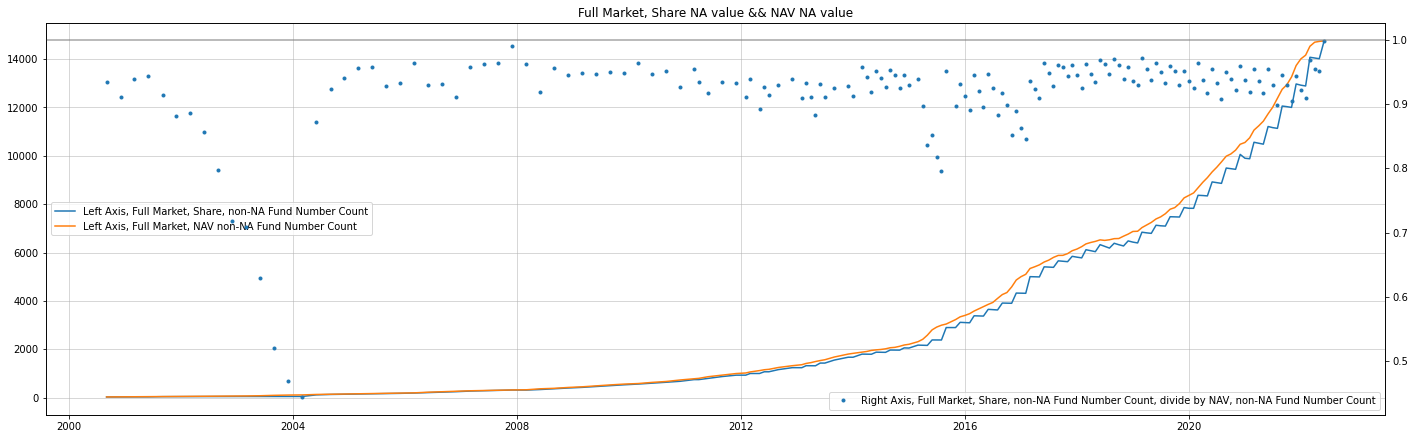

In [68]:
filled_share_info = compare_share_info.fillna(method='ffill')
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='Left Axis, Full Market, Share, non-NA Fund Number Count')
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='Left Axis, Full Market, NAV non-NA Fund Number Count')
ax1.legend(loc='center left')
ax1.grid(linewidth=.5)

ax2 = ax1.twinx()

pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index.astype(np.datetime64)).plot(style='.', label='Right Axis, Full Market, Share, non-NA Fund Number Count, divide by NAV, non-NA Fund Number Count')
plt.title('Full Market, Share NA value && NAV NA value')
ax2.legend(loc='lower right')

ax2.axhline(y=1, color='grey', alpha=.7)


Size effect in fund?

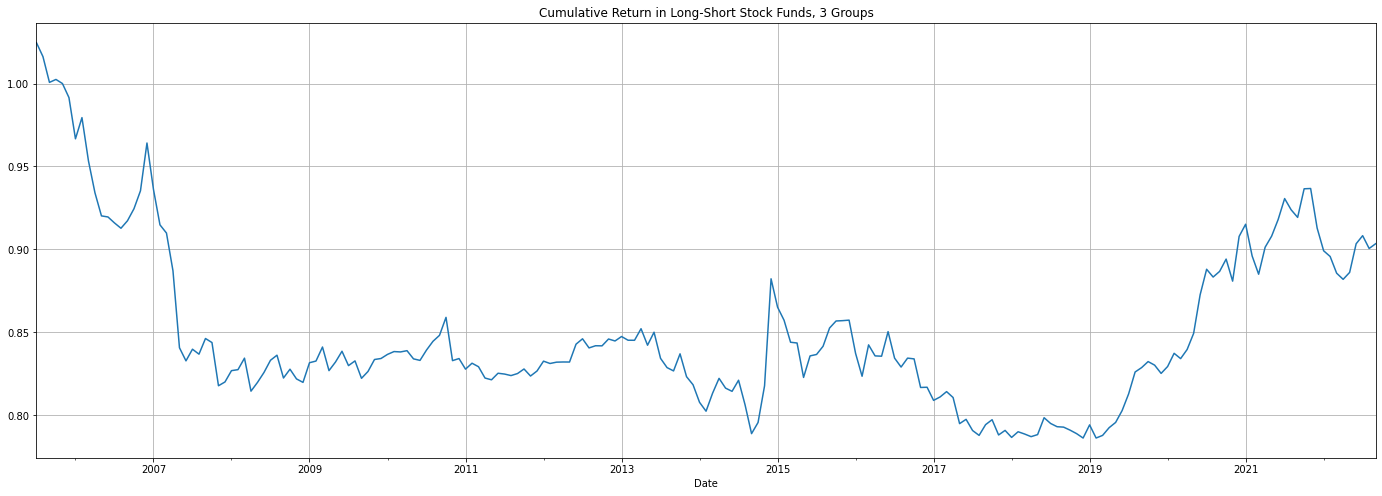

In [69]:
stock_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_csmar_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1).dropna()
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Stock Funds, {groups} Groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [70]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.4363630368132899, pvalue=0.6684848318998369)

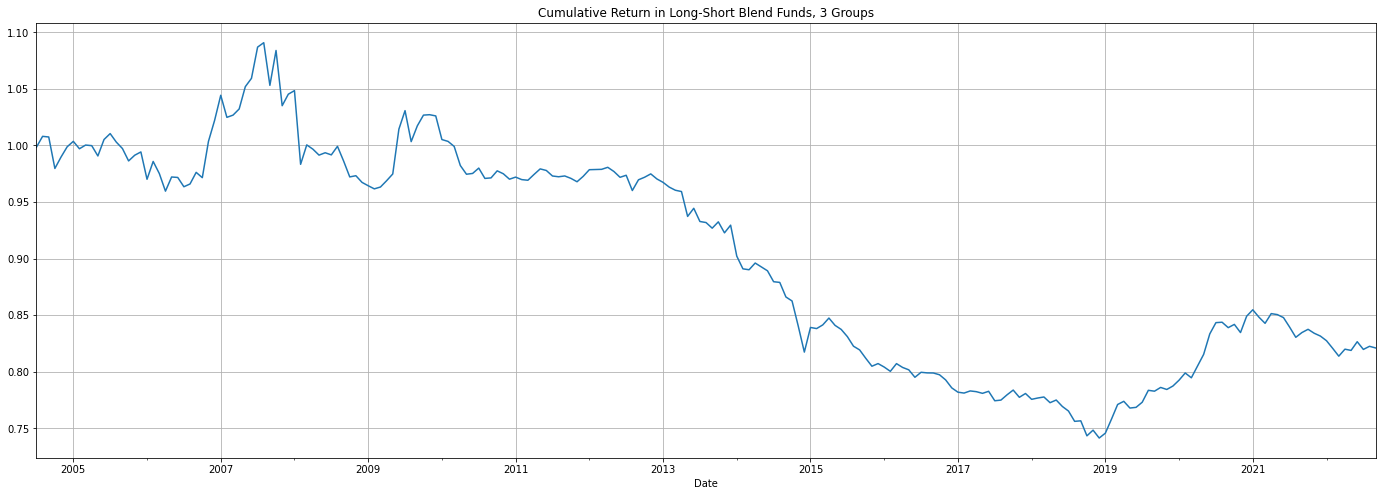

In [71]:
blend_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight_ = pd.concat([blend_fund_weight_, \
    pd.DataFrame([[np.nan] * blend_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight_.columns)])
blend_fund_weight_ = blend_fund_weight_.resample('M').ffill()

groups = 3
ret_blend_fund = return_of_csmar_blend_fund.unstack(0) - 1
blend_fund_groups = blend_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(blend_fund_groups.index, ret_blend_fund.index)
co_stocks = np.intersect1d(blend_fund_groups.columns, ret_blend_fund.columns)

blend_fund_groups = blend_fund_groups.loc[co_time, co_stocks]
ret_blend_fund = ret_blend_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, blend_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Blend Funds, {groups} Groups')
blend_grouped_return = ret_blend_fund.apply(func, axis=1).dropna()

(blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [72]:
stats.ttest_1samp((blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.0531885059552117, pvalue=0.85328973176576)

### Regression

In [ ]:
import pickle
import pandas as pd

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund

regression table construction

In [76]:
stock_fund_regression = ((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1)
stock_fund_regression.name = 'stock_fund'

blend_fund_regression = ((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1)
blend_fund_regression.name = 'blend_fund'


regression_source = pd.merge(stock_fund_regression, svc_source[['mktrf', 'rf', 'smb', 'vmg']], on='Date')
regression_source = pd.merge(regression_source, blend_fund_regression, on='Date')

regression_source['α'] = 1

regression_source = regression_source.loc['2005-6':]
regression_source

,stock_fund,mktrf,rf,smb,vmg,blend_fund,α
Date,,,,,,,
2005-06,0.006722,0.011522,0.001856,0.000517,0.056121,0.006346,1
2005-07,0.026240,-0.019041,0.001856,-0.051082,0.071114,0.019213,1
2005-08,0.030586,0.071589,0.001856,0.094712,-0.049516,0.021038,1
2005-09,-0.016050,0.001288,0.001856,0.033242,0.045120,0.001627,1
2005-10,-0.034043,-0.054595,0.001856,-0.001480,0.024557,-0.023199,1
...,...,...,...,...,...,...,...
2022-05,0.045655,0.052554,0.001241,0.064625,-0.012790,0.038071,1
2022-06,0.101454,0.088114,0.001241,-0.020506,-0.028009,0.086118,1
2022-07,-0.046780,-0.030989,0.001241,0.071198,-0.005291,-0.037448,1


naïve regression

In [77]:
stock_naïve = sm.OLS(regression_source.stock_fund, regression_source[['α']]).fit()
blend_naïve = sm.OLS(regression_source.blend_fund, regression_source[['α']]).fit()
stock_naïve_excess = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α']]).fit()
blend_naïve_excess = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α']]).fit()


In [78]:
pd.DataFrame(
[
[float_to_percent(stock_naïve.params[0]), stock_naïve.tvalues.iloc[0].round(3), stock_naïve.pvalues[0].round(3), yearly_return(stock_naïve)],
[float_to_percent(blend_naïve.params[0]), blend_naïve.tvalues.iloc[0].round(3), blend_naïve.pvalues[0].round(3), yearly_return(blend_naïve)],
[float_to_percent(stock_naïve_excess.params[0]), stock_naïve_excess.tvalues.iloc[0].round(3), stock_naïve_excess.pvalues[0].round(3), yearly_return(stock_naïve_excess)],
[float_to_percent(blend_naïve_excess.params[0]), blend_naïve_excess.tvalues.iloc[0].round(3), blend_naïve_excess.pvalues[0].round(3), yearly_return(blend_naïve_excess)],
],
index=['stock_naïve', 'blend_naïve', 'stock_naïve_excess', 'blend_naïve_excess'], columns=pd.Series(['α', 't', 'p', 'annual α'],\
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}'))

2005/6-2022/9,α,t,p,annual α
stock_naïve,1.091%,2.328,0.021,13.91%
blend_naïve,1.076%,2.930,0.004,13.71%
stock_naïve_excess,0.901%,1.921,0.056,11.36%
blend_naïve_excess,0.886%,2.410,0.017,11.17%


CAPM regression

In [81]:
stock_capm = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()
blend_capm = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()

In [82]:
pd.DataFrame(
[
[float_to_percent(stock_capm.params[0]) + ' (' + str(stock_capm.tvalues.iloc[0].round(3)) + ')', \
    str(stock_capm.params[1].round(3)) + ' (' + str(stock_capm.tvalues.iloc[1].round(3)) + ')',\
         stock_capm.rsquared, yearly_return(stock_capm)],
[float_to_percent(blend_capm.params[0]) + ' (' + str(blend_capm.tvalues.iloc[0].round(3)) + ')', \
    str(blend_capm.params[1].round(3)) + ' (' + str(blend_capm.tvalues.iloc[1].round(3)) + ')', \
        blend_capm.rsquared, yearly_return(blend_capm)],
],
columns=['α', 'mktrf', 'r^2', 'annual α'], index=pd.Series(['stock_capm', 'blend_capm'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_capm,blend_capm
α,0.154% (1.052),0.325% (2.128)
mktrf,0.826 (44.307),0.62 (31.82)
r^2,0.905032,0.830937
annual α,1.86%,3.97%


SVC regression

In [83]:
stock_svc = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()
blend_svc = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()

In [84]:
pd.DataFrame(
[
[float_to_percent(stock_svc.params[0]) + ' (' + str(stock_svc.tvalues.iloc[0].round(3)) + ')', \
    str(stock_svc.params[1].round(3)) + ' (' + str(stock_svc.tvalues.iloc[1].round(3)) + ')', \
        str(stock_svc.params[2].round(3)) + ' (' + str(stock_svc.tvalues.iloc[2].round(3)) + ')', \
            str(stock_svc.params[3].round(3)) + ' (' + str(stock_svc.tvalues.iloc[3].round(3)) + ')', \
                stock_svc.rsquared, yearly_return(stock_svc)],
[float_to_percent(blend_svc.params[0]) + ' (' + str(blend_svc.tvalues.iloc[0].round(3)) + ')', \
    str(blend_svc.params[1].round(3)) + ' (' + str(blend_svc.tvalues.iloc[1].round(3)) + ')', \
        str(blend_svc.params[2].round(3)) + ' (' + str(blend_svc.tvalues.iloc[2].round(3)) + ')', \
            str(blend_svc.params[3].round(3)) + ' (' + str(blend_svc.tvalues.iloc[3].round(3)) + ')', \
                blend_svc.rsquared, yearly_return(blend_svc)],
],

columns=['α', 'mktrf', 'smb', 'vmg', 'r^2', 'annual α'], index=pd.Series(['stock_svc', 'blend_svc'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_svc,blend_svc
α,0.323% (2.165),0.67% (4.294)
mktrf,0.838 (46.938),0.592 (31.72)
smb,-0.179 (-5.55),-0.063 (-1.867)
vmg,-0.024 (-0.569),-0.263 (-5.967)
r^2,0.919562,0.856929
annual α,3.95%,8.35%


## **V. Fund Evaluation**

### Method

step1, α, 每支基金，2005-2022滚动回归，窗口期3年，得到α面板数据

| date/fund | fund1 | fund2 | fund3 |
| --------- | ----- | ----- | ----- |
| date1     | 0.1   | 0.1   | 0.1   |
| date2     | 0.1   | 0.1   | 0.1   |
| date3     | 0.1   | 0.1   | 0.1   |

step2, fund_list, 每个日期，对上述α面板数据分低中高3组。保留每个日期中，低中高3组α对应的3个基金组合

| date/group | low                         | middle | high   |
| ---------- | --------------------------- | ------ | ------ |
| date1      | [ fund1, fund2, fund3, … ] | [ … ] | [ … ] |
| date2      | [ … ]                      | [ … ] | [ … ] |
| date3      | [ … ]                      | [ … ] | [ … ] |

step3, return, 对上述基金列表面板数据，对每个日期、每组基金，乘以其市值加权权重（市值与权重成正比），得到加权收益率

| date/group | low | middle | high |
| ---------- | --- | ------ | ---- |
| date1      | 0.1 | 0.1    | 0.1  |
| date2      | 0.1 | 0.1    | 0.1  |
| date3      | 0.1 | 0.1    | 0.1  |

step4, summary, 对上述收益率面板数据，按基金组别，与既有模型回归

| indicator/group | low | middle | high |
| --------------- | --- | ------ | ---- |
| α              | 0.1 | 0.1    | 0.1  |
| t               | 1   | 1      | 1    |

step5, summary, 整合多个模型统计结果

|   model-indicator/group     | model-indicator/group | low | middle | high |
| ------ | --------------------- | --- | ------ | ---- |
| model1 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |
| model2 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |
| model3 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |

### Utilities

In [85]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from utils.functions import *

from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.TwoStepData.all_fund_weight import all_fund_weight
from data.TwoStepData.regression_source import regression_source

In [86]:
all_fund_weight = csmar_share_info_yearly * csmar_nav_yearly
all_fund_weight = pd.concat([all_fund_weight, \
    pd.DataFrame([[np.nan] * all_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=all_fund_weight.columns)])
all_fund_weight = all_fund_weight.resample('M').ffill()

In [87]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

In [88]:

def group_and_statistic(α_matrix, groups = 5):

    grouped_all_fund_α_matrix = α_matrix.apply(lambda x: \
        pd.qcut(x, groups, labels=np.arange(groups)) if pd.notna(x).sum() >= groups else pd.Series([np.nan] * len(x), x.index), axis=1).dropna(how='all')

    def func(x):
        date = x.name
        weight = all_fund_weight.loc[date]
        return_look_forward = return_of_all_fund_.shift(-1)
        ret = return_look_forward.loc[date]

        result = pd.DataFrame([x, ret, weight], index=['rank', 'ret', 'weight']).T.dropna(subset='rank').sort_values(by='rank')
        result['weight'] = result.groupby('rank').apply(lambda y: y.weight / y.weight.sum()).values
        result = result.groupby('rank').apply(lambda y: (y.ret * y.weight).sum())
        return result

    grouped_all_fund_α_matrix_return = grouped_all_fund_α_matrix.apply(func, axis=1)


    # RS denotes regression source
    RS_α = pd.merge(grouped_all_fund_α_matrix_return, regression_source, on='Date')
    RS_α[['stock_fund', 'mktrf', 'rf', 'smb', 'vmg', 'blend_fund']] = RS_α[['stock_fund', 'mktrf', 'rf', 'smb', 'vmg', 'blend_fund']].shift(-1)
    RS_α = RS_α.iloc[:-1]

    regressors = [
        ['α'],
        ['α', 'mktrf'],
        ['α', 'mktrf', 'smb', 'vmg']
        ]
        
    results = []

    for regressor in regressors:

        for group in range(groups):
            temp = sm.OLS(RS_α[group] - RS_α.rf, RS_α[regressor]).fit()
            results.append([float_to_percent(temp.params[0]), yearly_return(temp), temp.tvalues[0].round(3), temp.rsquared.round(3)])
        # remove r_f
        temp = sm.OLS(RS_α[groups - 1] - RS_α[0], RS_α[regressor]).fit()
        results.append([float_to_percent(temp.params[0]), yearly_return(temp), temp.tvalues[0].round(3), temp.rsquared.round(3)])

    excess_result, capm_α_result, svc_α_result = results[0: groups + 1], results[groups + 1: 2 * groups + 2], results[2 * groups + 2: 3 * groups + 3]

    excess_result = pd.DataFrame(np.array(excess_result).T, \
        index=pd.MultiIndex.from_product([['excess'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(groups)] + ['long-short'])
    capm_α_result = pd.DataFrame(np.array(capm_α_result).T, \
        index=pd.MultiIndex.from_product([['capm α'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(groups)] + ['long-short'])
    svc_α_result = pd.DataFrame(np.array(svc_α_result).T, \
        index=pd.MultiIndex.from_product([['svc α'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(groups)] + ['long-short'])

    return pd.concat([excess_result, capm_α_result, svc_α_result])


def fund_ended_check(α_operation):
    def check_filter(x):
        if pd.notna(x[-1]):
            # if the fund is running now
            return α_operation(x)
        else:
            # if the fund is shut down
            return np.nan
    return check_filter


@fund_ended_check
def α_na_ratio(x):

    window_length = len(x)
    x = x.dropna()  
    return 1 - len(x) / window_length


In [89]:
MAX_NA_NUM = 35

return_of_all_fund_na_ratio = return_of_all_fund_.rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(α_na_ratio)
return_of_all_fund_na_ratio

Symbol,000001,000006,000011,000017,000020,000021,000029,000030,000031,000039,000042,000056,000057,000058,000059,000061,000063,000065,000066,000073,000082,000083,000110,000117,000120,000124,000126,000127,000136,000165,000166,000167,000172,000173,000176,000190,000195,000196,000199,000209,...,730002,740001,740101,750001,750005,762001,770001,910004,910006,910007,910009,910011,910017,910021,910022,910024,910028,952009,960000,960001,960002,960003,960004,960005,960006,960007,960008,960010,960011,960012,960016,960018,960020,960021,960022,960023,960024,960026,960028,960033
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.083333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.277778,0.277778,0.277778,0.444444,0.277778,0.277778,0.277778,0.277778,0.277778,NaN,0.277778,0.277778,0.277778,0.277778,0.277778,0.777778,NaN,NaN,0.444444,NaN,0.444444,0.777778
2019-03,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.055556,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.250000,0.250000,0.416667,0.250000,0.250000,0.250000,0.250000,0.250000,NaN,0.250000,0.250000,0.250000,0.250000,0.250000,0.750000,NaN,NaN,0.416667,NaN,0.416667,0.750000
2019-04,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.722222,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.027778,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,0.222222,0.222222,0.388889,0.222222,0.222222,0.222222,0.222222,0.222222,NaN,0.222222,0.222222,0.222222,0.222222,0.222222,0.722222,NaN,NaN,0.388889,NaN,0.388889,0.722222


### last 3 years' excess return on CAPM

In [90]:
from factors import *
from IPython.display import display

In [91]:
@fund_ended_check
def capm_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit().params[0]
    return α

all_fund_capm_α = return_of_all_fund_.rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_generation)

display(group_and_statistic(all_fund_capm_α))

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.942%   1.07%   1.08%  1.257%  1.205%     0.263%
       annual α     11.91%  13.63%  13.76%  16.17%  15.45%       3.2%
       t             1.686   1.907   1.933   2.232   2.075      1.482
       R^2            -0.0     0.0    -0.0     0.0    -0.0       -0.0
capm α α (monthly)  0.091%  0.222%  0.243%  0.471%  0.377%     0.286%
       annual α       1.1%   2.69%   2.95%    5.8%   4.62%      3.49%
       t             0.646   1.416    1.41   1.791    1.52      1.605
       R^2           0.938   0.924   0.907   0.787   0.821      0.007
svc α  α (monthly)  0.159%  0.323%  0.405%  0.524%  0.645%     0.486%
       annual α      1.92%   3.94%   4.97%   6.47%   8.02%      5.99%
       t             0.996   1.812   2.092   1.713   2.346       2.41
       R^2           0.942   0.928   0.914   0.788   0.839       0.07

### last 3 years' excess return on SVC

In [1]:
from factors import *
from IPython.display import display

In [3]:
@fund_ended_check
def svc_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit().params[0]
    return α

all_fund_svc_α = return_of_all_fund_.loc['2005-6':].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_generation)

display(group_and_statistic(all_fund_svc_α))

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.889%  1.017%  1.065%  1.287%  1.165%     0.276%
       annual α      11.2%  12.92%  13.56%  16.58%  14.91%      3.36%
       t             1.843   2.171   2.257   2.577   2.323      1.694
       R^2             0.0    -0.0     0.0     0.0     0.0       -0.0
capm α α (monthly)  0.114%  0.269%   0.32%  0.562%  0.414%       0.3%
       annual α      1.37%   3.28%   3.91%   6.96%   5.08%      3.66%
       t             0.899    2.01   2.116   2.274   1.874      1.833
       R^2           0.932    0.92   0.899   0.759   0.809      0.008
svc α  α (monthly)    0.2%  0.462%  0.627%    0.9%  0.985%     0.785%
       annual α      2.42%   5.68%   7.79%  11.35%  12.48%      9.84%
       t              1.43   3.187   3.985   3.357    4.53      5.231
       R^2           0.933   0.924   0.911    0.77    0.85      0.324

In [7]:
all_fund_svc_α.loc['2021-12'].sort_values().dropna()

Symbol
008998   -0.045966
008997   -0.045623
008293   -0.043450
009017   -0.040831
009277   -0.039284
            ...   
006977    0.052186
007690    0.053853
007689    0.054203
006736    0.057086
519969    0.228923
Name: 2021-12, Length: 3503, dtype: float64

In [33]:
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.SVC.svc_source import svc_source

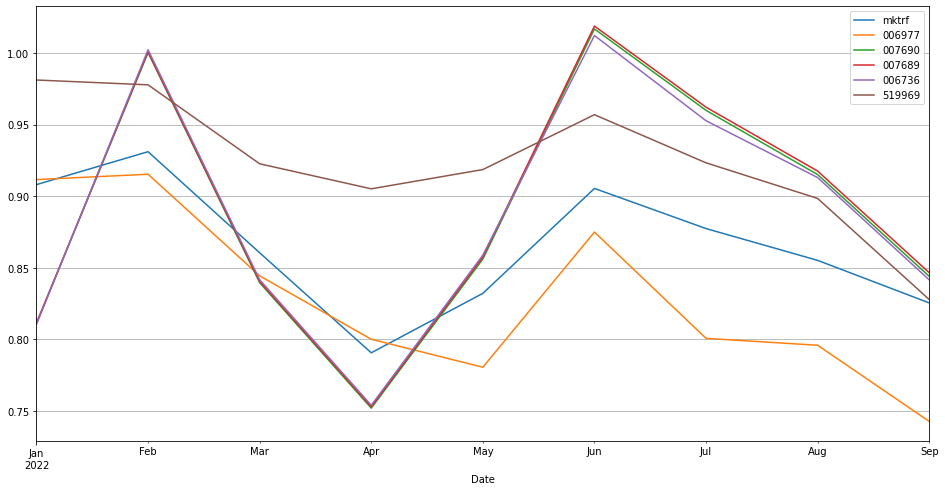

In [34]:
plt.figure(figsize=(16, 8))
(svc_source.loc['2022-1':, 'mktrf'] + 1).cumprod().plot()
return_of_all_fund.unstack().loc['006977', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['007690', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['007689', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['006736', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['519969', '2022-1':].cumprod().plot()
plt.legend()
plt.grid()

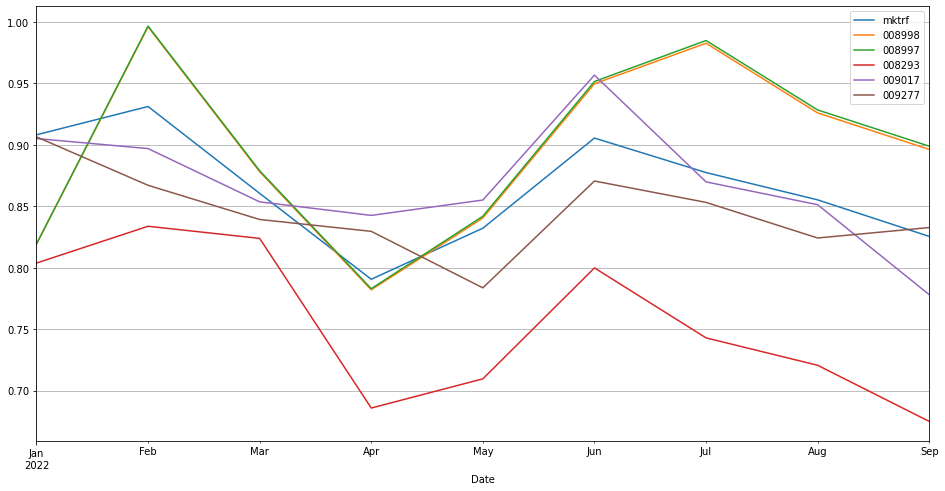

In [35]:
plt.figure(figsize=(16, 8))
(svc_source.loc['2022-1':, 'mktrf'] + 1).cumprod().plot()
return_of_all_fund.unstack().loc['008998', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['008997', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['008293', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['009017', '2022-1':].cumprod().plot()
return_of_all_fund.unstack().loc['009277', '2022-1':].cumprod().plot()
plt.legend()
plt.grid()

### industry concentration

In [122]:
from data.CSMAR.invest_detail import invest_detail
from data.JoinQuant.jq_stock_classification import jq_stock_classification
from data.CSMAR.TRD_Mnth import csmar_monthly_stock_mkt_value
from data.TwoStepData.return_of_all_fund import return_of_all_fund

In [123]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')
invest_detail_ = invest_detail_.rename(columns={'EndDate': 'Date'})
invest_detail_['Date'] = pd.to_datetime(invest_detail_.Date).dt.to_period('M')

month_mkt_value_ = pd.merge(csmar_monthly_stock_mkt_value, jq_stock_classification, on='Stkcd', validate='m:1')
month_mkt_value_ = month_mkt_value_.groupby(['Trdmnt', 'Indnme']).apply(lambda x: x.Msmvttl.sum())
month_mkt_value_ = month_mkt_value_.unstack().div(month_mkt_value_.unstack().sum(axis=1), axis=0).fillna(0)
month_mkt_value_.index = pd.to_datetime(month_mkt_value_.index).to_period('M')
month_mkt_value_.index.name = 'Date'


In [101]:

invest_industry_sum = invest_detail_.groupby(['Symbol', 'Date', 'Indnme']).apply(lambda x: x.Proportion.sum())

invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
invest_industry_proportion = invest_industry_proportion.unstack(level=[0, 2]).resample('M').ffill().fillna(method='ffill')
invest_industry_proportion = invest_industry_proportion.stack(0).swaplevel().sort_index().fillna(0)

month_mkt_value_ = pd.merge(invest_industry_proportion.reset_index()[['Symbol', 'Date']], month_mkt_value_, on='Date')\
    .set_index(['Symbol', 'Date']).sort_index()

In [105]:
industry_concentration = ((invest_industry_proportion - month_mkt_value_) ** 2).sum(axis=1)
industry_concentration = industry_concentration.unstack().T.loc['2005-6': '2019-6']

co_funds = np.intersect1d(industry_concentration.columns, return_of_all_fund_.columns)
industry_concentration = industry_concentration[co_funds]

In [106]:
# joinquant, sw_l1
group_and_statistic(industry_concentration, groups=5)

group0  group1  group2  group3  group4 long-short
excess α (monthly)   0.94%  0.921%  1.021%   0.91%  0.768%    -0.172%
       annual α     11.88%  11.63%  12.97%  11.49%   9.61%     -2.05%
       t             2.034   1.999   2.161   1.973   1.802      -1.21
       R^2             0.0    -0.0     0.0     0.0    -0.0       -0.0
capm α α (monthly)  0.262%  0.253%  0.367%  0.241%  0.165%    -0.097%
       annual α      3.19%   3.08%    4.5%   2.93%    2.0%     -1.16%
       t             1.555   1.401   1.617   1.332   0.875     -0.715
       R^2            0.87    0.85   0.774   0.849   0.808      0.113
svc α  α (monthly)   0.37%  0.516%   0.49%  0.529%  0.456%     0.086%
       annual α      4.54%   6.37%   6.04%   6.53%   5.61%      1.03%
       t             1.916    2.55   1.882   2.692   2.186      0.555
       R^2           0.874   0.862   0.782    0.87   0.828      0.158

### active share

In [17]:
import numpy as np

from IPython.display import display
from factors import *
from data.CSMAR.index_weight import *
from data.CSMAR.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

In [2]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')
invest_detail_ = invest_detail_.rename(columns={'EndDate': 'Date'})
invest_detail_['Date'] = pd.to_datetime(invest_detail_.Date).dt.to_period('M')

In [3]:
invest_detail_ = invest_detail_.drop_duplicates(['Symbol', 'Date', 'Stkcd'])
invest_detail_ = invest_detail_[invest_detail_.Date >= '2005-6']
invest_detail_ = invest_detail_.pivot(index=['Symbol', 'Date'], columns='Stkcd', values='Proportion')
invest_detail_ = invest_detail_.div(invest_detail_.sum(axis=1), axis=0) * 100


In [4]:
hs300_weight_in_csmar_form = pd.DataFrame(columns=csmar_hs300_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_hs300_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

hs300_co_stocks = np.intersect1d(invest_detail_.columns, hs300_weight_in_csmar_form.columns)
hs300_AS = (np.abs(hs300_weight_in_csmar_form[hs300_co_stocks] - invest_detail_[hs300_co_stocks])).sum(axis=1) / 2

sz50_weight_in_csmar_form = pd.DataFrame(columns=csmar_sz50_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_sz50_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

sz50_co_stocks = np.intersect1d(invest_detail_.columns, csmar_sz50_weight.columns)
sz50_AS = (np.abs(sz50_weight_in_csmar_form[sz50_co_stocks] - invest_detail_[sz50_co_stocks])).sum(axis=1) / 2

zz500_weight_in_csmar_form = pd.DataFrame(columns=csmar_zz500_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_zz500_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

zz500_co_stocks = np.intersect1d(invest_detail_.columns, csmar_zz500_weight.columns)
zz500_AS = (np.abs(zz500_weight_in_csmar_form[zz500_co_stocks] - invest_detail_[zz500_co_stocks])).sum(axis=1) / 2

In [76]:
active_share = pd.concat([hs300_AS, zz500_AS, sz50_AS], axis=1).replace(0, np.inf).min(axis=1).unstack(0)
co_funds = np.intersect1d(active_share.columns, return_of_all_fund_.columns)
active_share = active_share[co_funds].replace(np.inf, np.nan).loc['2005-6' : '2019-6']

In [66]:
group_and_statistic(active_share.ffill())


group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.988%  0.948%  1.154%  0.965%  1.006%     0.018%
       annual α     12.52%  11.99%  14.76%  12.21%  12.76%      0.22%
       t             1.801   1.698   1.917   1.833   1.872      0.167
       R^2             0.0    -0.0     0.0     0.0     0.0        0.0
capm α α (monthly)  0.552%  0.511%  0.732%  0.553%   0.56%     0.008%
       annual α      6.83%   6.31%   9.15%   6.84%   6.93%      0.09%
       t             1.302   1.172   1.461   1.344   1.393       0.07
       R^2           0.415   0.403   0.323   0.404   0.454      0.006
svc α  α (monthly)  0.587%  0.514%   0.49%  0.542%  0.526%    -0.061%
       annual α      7.27%   6.35%   6.04%   6.71%   6.49%     -0.73%
       t             1.168     1.0   0.828   1.122   1.101     -0.474
       R^2           0.421   0.413   0.333   0.418   0.455      0.054

In [82]:
pickle.load(open('data/IDV/IDV.pkl', 'rb')).sort_values('TRADE_DT')

,S_INFO_WINDCODE,TRADE_DT,idvc12,idvc6,idvc1,idvff12,idvff6,idvff1
0,000001.SZ,2018-01-02,0.231366,0.305013,0.218050,0.204603,0.264671,0.173231
3483278,600853.SH,2018-01-02,0.314176,0.166222,0.157621,0.305469,0.129216,0.085547
3484436,600854.SH,2018-01-02,0.368951,0.308652,0.293492,0.356570,0.290831,0.218192
574360,002033.SZ,2018-01-02,0.161756,0.166672,NaN,0.144637,0.146351,NaN
3485594,600855.SH,2018-01-02,NaN,0.330433,0.263233,NaN,0.295450,0.237559
...,...,...,...,...,...,...,...,...
3047362,600397.SH,2022-10-12,0.558695,0.585877,0.679879,0.492252,0.544325,0.551549
2546380,300826.SZ,2022-10-12,0.347865,0.301766,0.231053,0.284100,0.237220,0.164411
3721242,601600.SH,2022-10-12,0.399890,0.292488,0.350421,0.356064,0.275439,0.297902
4418484,605228.SH,2022-10-12,0.342264,0.386390,0.429119,0.313796,0.347199,0.375263
